In [31]:
import random
import pandas as pd
import numpy as np
import tensorflow as tf
from tqdm import tqdm
from scipy import stats
from truesight.preprocessing import Preprocessor
from truesight.core import TrueSight
from truesight.metrics import Evaluator, smape, mape, mse, rmse, mae
from sklearn.metrics import r2_score
from truesight.utils import generate_syntetic_data

seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [51]:
df = pd.read_csv('datasets\\Stallion\\train_OwBvO8W\\historical_volume.csv')
df['YearMonth'] = pd.to_datetime(df['YearMonth'], format = '%Y%m')
df.rename(columns = {'YearMonth': 'ds', 'Volume': 'y'}, inplace = True)
df['unique_id'] = df['Agency'] + '-' + df['SKU']
df = df[['unique_id', 'ds', 'y']]

In [60]:
season_length = 12
forecast_horizon = 12

In [61]:
from statsforecast.models import SeasonalNaive, AutoETS, AutoARIMA
from sklearn.linear_model import LinearRegression
from truesight.utils import ModelWrapper

models = [
    ModelWrapper(LinearRegression, horizon=forecast_horizon, season_length=season_length, alias="LinearRegression"),
    ModelWrapper(AutoETS, horizon=forecast_horizon, season_length=season_length),
    ModelWrapper(AutoARIMA, horizon=forecast_horizon, season_length=season_length),
]

preprocessor = Preprocessor(df)
X_train, Y_train, ids_train, X_val, Y_val, ids_val, models = preprocessor.make_dataset(
    forecast_horizon = forecast_horizon, 
    season_length = season_length,
    date_freq = "MS", 
    models = models, 
    fallback_model = ModelWrapper(SeasonalNaive, horizon=forecast_horizon, season_length=season_length),
    verbose = True
    )

  0%|          | 0/280 [00:00<?, ?it/s]

100%|██████████| 70/70 [00:40<00:00,  1.73it/s]


Epoch 1/1000
9/9 [==============================] - 7s 328ms/step - loss: 11280633.0000 - val_loss: 6668126.0000 - lr: 1.0000e-04
Epoch 2/1000
9/9 [==============================] - 2s 266ms/step - loss: 11238494.0000 - val_loss: 6627058.0000 - lr: 1.0000e-04
Epoch 3/1000
9/9 [==============================] - 2s 263ms/step - loss: 11169318.0000 - val_loss: 6556872.0000 - lr: 1.0000e-04
Epoch 4/1000
9/9 [==============================] - 2s 264ms/step - loss: 11068486.0000 - val_loss: 6446774.0000 - lr: 1.0000e-04
Epoch 5/1000
9/9 [==============================] - 2s 268ms/step - loss: 10883048.0000 - val_loss: 6285288.5000 - lr: 1.0000e-04
Epoch 6/1000
9/9 [==============================] - 2s 260ms/step - loss: 10630680.0000 - val_loss: 6053461.5000 - lr: 1.0000e-04
Epoch 7/1000
9/9 [==============================] - 2s 266ms/step - loss: 10277678.0000 - val_loss: 5764628.5000 - lr: 1.0000e-04
Epoch 8/1000
9/9 [==============================] - 2s 262ms/step - loss: 9858854.0000 - v

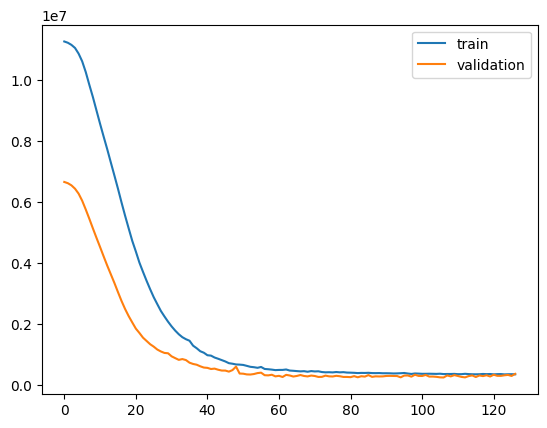

Epoch 1/1000
9/9 [==============================] - 7s 322ms/step - loss: 11280399.0000 - val_loss: 6668082.5000 - lr: 1.0000e-04
Epoch 2/1000
9/9 [==============================] - 2s 268ms/step - loss: 11239664.0000 - val_loss: 6628289.5000 - lr: 1.0000e-04
Epoch 3/1000
9/9 [==============================] - 2s 277ms/step - loss: 11173398.0000 - val_loss: 6560744.5000 - lr: 1.0000e-04
Epoch 4/1000
9/9 [==============================] - 2s 280ms/step - loss: 11076783.0000 - val_loss: 6455652.5000 - lr: 1.0000e-04
Epoch 5/1000
9/9 [==============================] - 3s 280ms/step - loss: 10903334.0000 - val_loss: 6307694.5000 - lr: 1.0000e-04
Epoch 6/1000
9/9 [==============================] - 2s 277ms/step - loss: 10681651.0000 - val_loss: 6104274.5000 - lr: 1.0000e-04
Epoch 7/1000
9/9 [==============================] - 2s 275ms/step - loss: 10379419.0000 - val_loss: 5852224.5000 - lr: 1.0000e-04
Epoch 8/1000
9/9 [==============================] - 3s 288ms/step - loss: 10010474.0000 - 

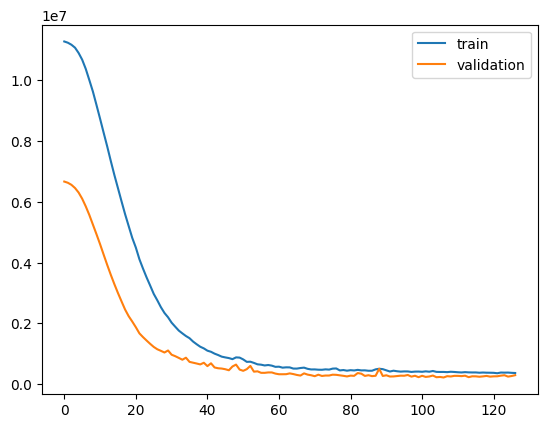

In [62]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience = 20, restore_best_weights = True, monitor = "val_loss"),
    tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss", factor = 0.5, patience = 10, verbose = False),
]

if True:
    models_nocov = models[-1:]
    X_train_nocov = X_train[-1:]
    X_val_nocov = X_val[-1:]

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    ts_nocov = TrueSight(models_nocov, forecast_horizon, filter_size = 64, context_size = 256, hidden_size = 1024, dropout_rate = 0.1)
    ts_nocov.compile(optimizer=optimizer, loss='mse')

    ts_nocov.fit(
        x = X_train_nocov, y = Y_train,
        validation_data = [X_val_nocov, Y_val],
        batch_size = 32,
        epochs = 1000,
        verbose = True,
        callbacks = callbacks,
    )
    ts_nocov.plot_training_history()
    ts_nocov.save_weights('nocov.h5')

    models_wcov = models.copy()
    X_train_wcov = X_train.copy()
    X_val_wcov = X_val.copy()

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    ts_wcov= TrueSight(models_wcov, forecast_horizon, filter_size = 64, context_size = 256, hidden_size = 1024, dropout_rate = 0.1)
    ts_wcov.compile(optimizer=optimizer, loss='mse')

    ts_wcov.fit(
        x = X_train_wcov, y = Y_train,
        validation_data = [X_val_wcov, Y_val],
        batch_size = 32,
        epochs = 1000,
        verbose = True,
        callbacks = callbacks,
    )
    ts_wcov.plot_training_history()
    ts_wcov.save_weights('ts_wcov.h5')

    yhat_nocov = ts_nocov.predict(X_val_nocov, n_repeats = 100, n_quantiles = 15, verbose = False)
    yhat_wcov = ts_wcov.predict(X_val_wcov, n_repeats = 100, n_quantiles = 15, verbose = False)
else:
    yhat_nocov = np.load('/content/drive/MyDrive/Forecast-M5/yhat_nocov.npy')
    yhat_wcov = np.load('/content/drive/MyDrive/Forecast-M5/yhat_wcov.npy')

In [63]:
evaluator_wcov = Evaluator(X_val, Y_val, yhat_wcov, ids_val)
evaluator_wcov.evaluate_prediction(evaluators = [smape, mape, mse, rmse, mae], return_mean = True)

smape         0.629153
mape          2.180737
mse      249746.194503
rmse        256.869388
mae         219.979002
dtype: float64

In [64]:
evaluator_nocov = Evaluator(X_val, Y_val, yhat_nocov, ids_val)
evaluator_nocov.evaluate_prediction(evaluators = [smape, mape, mse, rmse, mae], return_mean = True)

smape         0.771634
mape          3.408208
mse      274628.012346
rmse        263.697013
mae         222.152117
dtype: float64

In [65]:
r2_score(Y_val, yhat_wcov.mean(axis=0))

0.9482142814595557

In [66]:
r2_score(Y_val, yhat_nocov.mean(axis=0))

0.9450317545568955

In [67]:
group_a = r2_score(Y_val.T, yhat_wcov.mean(axis=0).T, multioutput='raw_values')
group_b = r2_score(Y_val.T, yhat_nocov.mean(axis=0).T, multioutput='raw_values')

t_statistic, p_value = stats.ttest_ind(group_a, group_b)

print("T-Statistic:", t_statistic)
print("P-Value:", p_value)

T-Statistic: -0.29283126372256046
P-Value: 0.7700909799168172


In [68]:
group_a = smape(Y_val, yhat_wcov.mean(axis=0))
group_b = smape(Y_val, yhat_nocov.mean(axis=0))

t_statistic, p_value = stats.ttest_ind(group_a, group_b)

print("T-Statistic:", t_statistic)
print("P-Value:", p_value)

T-Statistic: -1.4312017493579878
P-Value: 0.15463312297177867


In [69]:
group_a = mape(Y_val, yhat_wcov.mean(axis=0))
group_b = mape(Y_val, yhat_nocov.mean(axis=0))

t_statistic, p_value = stats.ttest_ind(group_a, group_b)

print("T-Statistic:", t_statistic)
print("P-Value:", p_value)

T-Statistic: -1.1085152594998897
P-Value: 0.2695675404501063


In [70]:
group_a = mse(Y_val, yhat_wcov.mean(axis=0))
group_b = mse(Y_val, yhat_nocov.mean(axis=0))

t_statistic, p_value = stats.ttest_ind(group_a, group_b)

print("T-Statistic:", t_statistic)
print("P-Value:", p_value)

T-Statistic: -0.18805217331727578
P-Value: 0.8511119919611729


In [71]:
group_a = rmse(Y_val, yhat_wcov.mean(axis=0))
group_b = rmse(Y_val, yhat_nocov.mean(axis=0))

t_statistic, p_value = stats.ttest_ind(group_a, group_b)

print("T-Statistic:", t_statistic)
print("P-Value:", p_value)

T-Statistic: -0.09094937647855104
P-Value: 0.9276646971579723


In [72]:
group_a = mae(Y_val, yhat_wcov.mean(axis=0))
group_b = mae(Y_val, yhat_nocov.mean(axis=0))

t_statistic, p_value = stats.ttest_ind(group_a, group_b)

print("T-Statistic:", t_statistic)
print("P-Value:", p_value)

T-Statistic: -0.03354332565755193
P-Value: 0.9732897842251591
